# Real data, v0

This notebook is a first attempt at running the model on the O'Neil dataset.

I'll not do anything clever with the kernels, just want to get a basic thing up and running, with the LMC, permutation invariance and SVI all working together.


But I'll start it off with modelling several drug combinations for a single cell line, i.e. a single-output permutation invariant GP. I'll use a basic fingerprint to represent the drugs, and then PCA to get the dimensionality down.

In [1]:
import pandas as pd
import numpy as np
import gauche
from gauche.dataloader import MolPropLoader
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
loader = MolPropLoader()
drugs = pd.read_csv("../synpred/data/ONeil_drug_SMILES.csv")
data = pd.read_csv("../synpred/data/Oneil_full.csv",delimiter=";")

In [2]:
# Processing drug SMILES
loader.read_csv("../synpred/data/ONeil_drug_SMILES.csv",smiles_column="SMILES",label_column="Numeric",validate=True)
loader.featurize('ecfp_fingerprints')
X = loader.features
scaler = StandardScaler()
X = scaler.fit_transform(X)
pcacomponents = 20
pca = PCA(n_components=pcacomponents)
X = pca.fit_transform(X)
print("ratio variance explained: ",pca.explained_variance_ratio_.sum())

# Merging onto the main dataframe
X = pd.DataFrame(X)
X = X.apply(zscore)
XA = X.add_prefix("A")
XB = X.add_prefix("B")
drugsA = pd.concat([drugs,XA],axis=1)
drugsA = drugsA.drop(columns=["Target","SMILES","Numeric"],axis=1)
drugsB = pd.concat([drugs,XB],axis=1)
drugsB = drugsB.drop(columns=["Target","SMILES","Numeric"],axis=1)
data = pd.merge(data,drugsA, left_on="DrugA",right_on="Name")
data = pd.merge(data,drugsB, left_on="DrugB",right_on="Name")
data = data.drop(columns=["Name_x","Name_y"])

ratio variance explained:  0.7246970017965706


In [3]:
data = data.sort_values(["CellLine","DrugA","DrugB"])

In [4]:
# Now let's subsample this, so that we have a single cell line of data to train on.
k = 4*583*100
#k = 1*583*100
data = data.head(k)

In [5]:
data.shape

(233200, 52)

In [6]:
data["CellLine"].unique()

array(['A2058', 'A2780', 'A375', 'A427'], dtype=object)

In [7]:
data

,CellLine,DrugA,DrugB,DrugAconc,DrugBconc,GPMean,GPVar,fMean,fVAR,p0Mean,...,B10,B11,B12,B13,B14,B15,B16,B17,B18,B19
0,A2058,5-FU,ABT-888,0.0,0.000000,-0.086238,0.769223,0.999311,0.000007,0.999129,...,-0.047116,-0.420439,-0.302607,-0.030364,0.477238,-0.313024,-0.131756,0.316169,0.392657,-0.445148
1,A2058,5-FU,ABT-888,0.0,0.111111,-0.109674,0.765477,0.999055,0.000011,0.998892,...,-0.047116,-0.420439,-0.302607,-0.030364,0.477238,-0.313024,-0.131756,0.316169,0.392657,-0.445148
2,A2058,5-FU,ABT-888,0.0,0.222222,-0.137490,0.769211,0.998608,0.000018,0.998559,...,-0.047116,-0.420439,-0.302607,-0.030364,0.477238,-0.313024,-0.131756,0.316169,0.392657,-0.445148
3,A2058,5-FU,ABT-888,0.0,0.333333,-0.169852,0.751210,0.997828,0.000034,0.998071,...,-0.047116,-0.420439,-0.302607,-0.030364,0.477238,-0.313024,-0.131756,0.316169,0.392657,-0.445148
4,A2058,5-FU,ABT-888,0.0,0.444444,-0.209794,0.726083,0.996413,0.000075,0.997321,...,-0.047116,-0.420439,-0.302607,-0.030364,0.477238,-0.313024,-0.131756,0.316169,0.392657,-0.445148
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2102495,A427,geldanamycin,Topotecan,1.0,0.555556,1.200413,0.199546,0.247642,0.002981,0.081938,...,0.281785,1.797706,-1.427424,-0.665044,-0.196894,0.563144,-0.669953,0.422424,0.050580,-0.477690
2102496,A427,geldanamycin,Topotecan,1.0,0.666667,1.257875,0.196916,0.173162,0.001481,0.050949,...,0.281785,1.797706,-1.427424,-0.665044,-0.196894,0.563144,-0.669953,0.422424,0.050580,-0.477690
2102497,A427,geldanamycin,Topotecan,1.0,0.777778,1.145956,0.251098,0.102279,0.000976,0.030932,...,0.281785,1.797706,-1.427424,-0.665044,-0.196894,0.563144,-0.669953,0.422424,0.050580,-0.477690
2102498,A427,geldanamycin,Topotecan,1.0,0.888889,0.816330,0.280116,0.052387,0.000400,0.020999,...,0.281785,1.797706,-1.427424,-0.665044,-0.196894,0.563144,-0.669953,0.422424,0.050580,-0.477690


In [8]:
data["DrugB"].unique()

array(['ABT-888', 'AZD1775', 'BEZ-235', 'Bortezomib', 'Dasatinib',
       'Dinaciclib', 'Erlotinib', 'L778123', 'Lapatinib', 'MK-2206',
       'MK-4827', 'MK-5108', 'MK-8669', 'MK-8776', 'PD325901',
       'Sorafenib', 'Sunitinib', 'Temozolomide', 'Zolinza',
       'geldanamycin', 'Oxaliplatin', 'SN-38', 'Topotecan', 'Etoposide',
       'Gemcitabine', 'Vinorelbine', '5-FU', 'Carboplatin',
       'Cyclophosphamide', 'Dexamethasone', 'Doxorubicin', 'MRK-003',
       'Metformin', 'Methotrexate', 'Mitomycine', 'Paclitaxel',
       'Vinblastine'], dtype=object)

In [9]:
# Now setting up code to run models
from matplotlib import pyplot as plt
import torch
import gpytorch
import numpy as np
import linear_operator
y = torch.tensor(data["fMean"].values).float()
s = torch.tensor(data["GPVar"].values).float()
conc = data[['DrugAconc','DrugBconc']]
drugcovars = data.iloc[:,-40:]
X = torch.tensor(pd.concat([conc,drugcovars],axis=1).values).float()
n_train = int(0.8*X.size(0))
randperm = torch.randperm(X.size(0))
X_train = X[randperm[:n_train],:]
X_test = X[randperm[n_train:],:]
y_train = y[randperm[:n_train]]
y_test = y[randperm[n_train:]]
task_indices = torch.tensor(pd.Categorical(data['CellLine']).codes).long()
task_train = task_indices[randperm[:n_train]]
task_test = task_indices[randperm[n_train:]]
num_tasks = task_indices.max().item() + 1

In [10]:
X_test.shape

torch.Size([46640, 42])

In [11]:

# Now going to get it ready for minibatching
from torch.utils.data import TensorDataset, DataLoader
train_dataset = TensorDataset(X_train, y_train, task_train)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)

In [12]:
X_train.size(1)

42

In [13]:
ind_indices = torch.randperm(X_train.size(0))
X1 = X_train[ind_indices[:10000]]
X2 = X_train[ind_indices[1000:2000]]

In [14]:
X_train.size(0)

186560

In [15]:
X1.unique(dim=0).shape

torch.Size([9348, 42])

In [22]:
from synpred.variational.permutation_invariant_variational_strategy import PermutationInvariantVariationalStrategy
from gpytorch.variational import LMCVariationalStrategy

class DrugCombModel(gpytorch.models.ApproximateGP):
    def __init__(self):
        print("Init is run!")
        num_latents = 4
        # Permutation
        permutation = torch.cat([torch.tensor([1]),torch.tensor([0]),torch.linspace(22,41,20),torch.linspace(2,21,20)]).long()
        # Inducing points init from training data
        ind_indices = torch.randperm(X_train.size(0))
        inducing_points = torch.stack([X_train[ind_indices[:250]],
                                       X_train[ind_indices[250:500]],
                                       X_train[ind_indices[500:750]],
                                       X_train[ind_indices[750:1000]]],
                                       #X_train[ind_indices[2000:2500]],
                                       #X_train[ind_indices[2500:3000]]],
                                       dim=0)
        # Variational distribution
        variational_distribution = gpytorch.variational.NaturalVariationalDistribution(
            inducing_points.size(-2), batch_shape=torch.Size([num_latents]))
        
        
        # Variational Strategy
        variational_strategy = LMCVariationalStrategy(
            PermutationInvariantVariationalStrategy(
                self, inducing_points, variational_distribution, 
                permutation=permutation,
                learn_inducing_locations=True),
            num_tasks=num_tasks,
            num_latents=num_latents,
            latent_dim=-1)

        
        super(DrugCombModel,self).__init__(variational_strategy)
        
        # Mean and covariance modules
        # Standard zero-mean
        self.mean_module = gpytorch.means.ZeroMean(batch_shape=torch.Size([num_latents]))
        # Covar over the concentrations, simple RBF
        self.covar_module_concentrations = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(active_dims=torch.tensor([0,1]),
                                                                     batch_shape=torch.Size([num_latents])),
                                                                        batch_shape=torch.Size([num_latents]))
        # Covar over the drugs, RBF + ARD
        self.covar_module_drugs = gpytorch.kernels.RBFKernel(active_dims=torch.linspace(2,41,40).long(),
                                                            ard_num_dims=40,
                                                            batch_shape=torch.Size([num_latents]))
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        # Final covariance is a simple product.
        covar_x = self.covar_module_concentrations(x) * self.covar_module_drugs(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


Init is run!
Init is run!
Old loss:  2.5327672958374023
New loss:  2.288741111755371
Init is run!
Init is run!
Init is run!
Old loss:  2.288741111755371
New loss:  2.0128228664398193
Init is run!
Old loss:  2.0128228664398193
New loss:  1.81281578540802
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Old loss:  1.81281578540802
New loss:  1.7767912149429321
Init is run!
Old loss:  1.7767912149429321
New loss:  1.6520569324493408
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init is run!
Init

In [25]:
# Check that initialization is decent
init_loss = []
#models = []
#likelihoods = []
ind = torch.randperm(X_train.size(0))
X_mll = X_train[ind[:1000]]
y_mll = y_train[ind[:1000]]
task_mll = task_train[ind[:1000]]
model = DrugCombModel()
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model.train()
likelihood.train()
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))
output = model(X_mll,task_indices=task_mll)
loss = -mll(output, y_mll)
for i in range(100):
    # Now continue in 
    newmodel = DrugCombModel()
    newlikelihood = gpytorch.likelihoods.GaussianLikelihood()
    newmodel.train()
    newlikelihood.train()
    newmll = gpytorch.mlls.VariationalELBO(newlikelihood, newmodel, num_data=y_train.size(0))
    newoutput = newmodel(X_mll,task_indices=task_mll)
    newloss = -newmll(newoutput, y_mll)
    # If this loss is better overwrite
    if newloss.item() < loss.item():
        print("Old loss: ", loss.item())
        print("New loss: ", newloss.item())
        model = newmodel
        likelihood = newlikelihood
        loss = newloss
        
    else:
        # Delete everthing
        import gc
        del newmodel
        del newlikelihood
        del newloss
        del newmll
        del newoutput
        del newloss
        gc.collect()


489

In [26]:
# this is for running the notebook in our testing framework
import os
import tqdm.notebook
from torch.optim.lr_scheduler import MultiStepLR
num_epochs = 30 # Number of complete passes through the data


model.train()
likelihood.train()

variational_ngd_optimizer = gpytorch.optim.NGD(model.variational_parameters(), lr=0.1,
                                               num_data=y_train.size(0))

hyperparameter_optimizer = torch.optim.Adam([
    {'params': model.hyperparameters()},
    {'params': likelihood.parameters()},
], lr=0.01)
scheduler_variational = MultiStepLR(variational_ngd_optimizer, milestones=[0.5 * num_epochs,
                                                                           0.75 * num_epochs
                                                                           ], gamma=0.1)
scheduler_hypers = MultiStepLR(hyperparameter_optimizer, milestones=[0.5 * num_epochs,
                                                                     0.75 * num_epochs
                                                                     ], gamma=0.1)


# Our loss object. We're using the VariationalELBO, which essentially just computes the ELBO
mll = gpytorch.mlls.VariationalELBO(likelihood, model, num_data=y_train.size(0))

# Tracking loss
train_loss  = []

# We use more CG iterations here because the preconditioner introduced in the NeurIPS paper seems to be less
# effective for VI.
with gpytorch.settings.cholesky_max_tries(3):
    epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
    for i in epochs_iter:
        # Within each iteration, we will go over each minibatch of data
        minibatch_iter = tqdm.notebook.tqdm(train_loader, desc="Minibatch", leave=False)
        counter = 0
        for x_batch, y_batch, task_batch in minibatch_iter:
            if (counter==5): # Update Variational parameters only every 5th iteration
                ### Perform NGD step to optimize variational parameters
                variational_ngd_optimizer.zero_grad()
                output = model(x_batch,task_indices=task_batch)
                loss = -mll(output, y_batch)
                loss.backward()
                variational_ngd_optimizer.step()
                counter = 0

            ### Perform Adam step to optimize hyperparameters
            hyperparameter_optimizer.zero_grad()
            output = model(x_batch,task_indices=task_batch)
            loss = -mll(output, y_batch)
            loss.backward()
            hyperparameter_optimizer.step()

            counter += 1
            #print(model.variational_strategy.lmc_coefficients)
            
            train_loss.append(loss.item())
            
            minibatch_iter.set_postfix(loss=loss.item())
            epochs_iter.set_postfix(loss=loss.item())
        
        scheduler_hypers.step()
        scheduler_variational.step()
        

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

Minibatch:   0%|          | 0/365 [00:00<?, ?it/s]

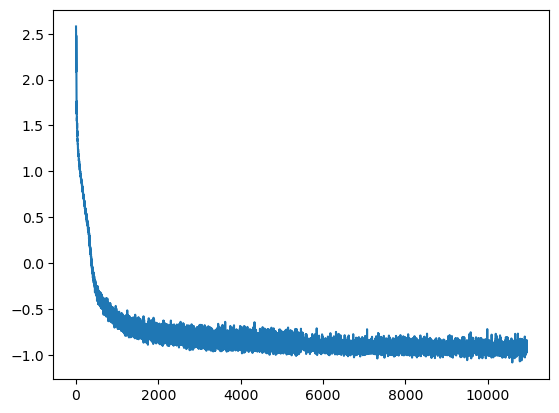

In [27]:
plt.plot(train_loss)

In [28]:
set(model.hyperparameters())

{Parameter containing:
 tensor([-4.0043, -4.2331, -3.5489, -2.2093], requires_grad=True),
 Parameter containing:
 tensor([[ 0.0101, -0.1154,  0.0829,  0.1435],
         [ 0.1573, -0.0289, -0.1286,  0.0105],
         [-0.0459, -0.1573, -0.0212, -0.1511],
         [ 0.1231,  0.1065,  0.1261,  0.1083]], requires_grad=True),
 Parameter containing:
 tensor([[[ 3.8522,  7.1658,  3.3058,  1.3965,  7.2463,  4.4148,  4.4968,
            4.2367,  3.9860,  7.8892,  2.9893,  0.1270,  5.0409,  0.7210,
           -1.7278,  3.7056,  0.8476,  2.9761,  5.1272,  0.3704, 13.4450,
            9.8488,  9.0739,  8.8240, 17.1420, 11.1875, 15.0125, 10.2460,
            6.9435, 15.8298, 12.3757, 15.0824, 13.2700, 16.2551, 10.8159,
           15.5836, 15.5496, 14.8238, 12.5410, 13.5768]],
 
         [[11.6521,  6.9829, 10.0313,  9.9819, 13.8619,  6.7701, 11.4393,
           12.8025,  7.7153, 16.1599, 13.3721, 12.2494, 11.3525, 11.7499,
           11.9304, 12.3924, 13.4126,  8.8144, 10.6377, 10.3752,  5.0480,
  

In [29]:
model.variational_strategy.lmc_coefficients.t().detach()

tensor([[ 0.0101,  0.1573, -0.0459,  0.1231],
        [-0.1154, -0.0289, -0.1573,  0.1065],
        [ 0.0829, -0.1286, -0.0212,  0.1261],
        [ 0.1435,  0.0105, -0.1511,  0.1083]])

In [30]:
model.covar_module_concentrations.lengthscale

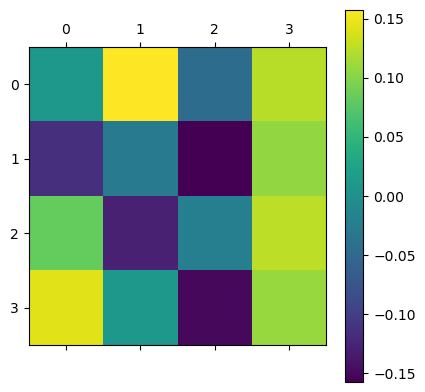

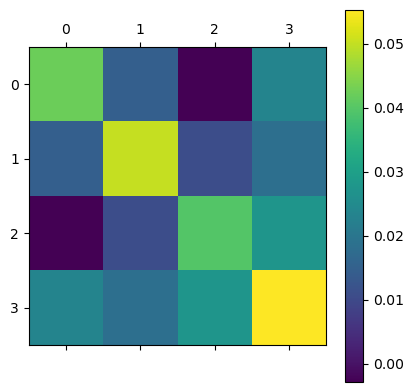

In [31]:
A = model.variational_strategy.lmc_coefficients.t().detach()
plt.matshow(A)
plt.colorbar()
plt.matshow(A.matmul(A.t()))
plt.colorbar()

In [32]:
indices = torch.randperm(X_test.size(0))[:2000]
X_test_subsample = X_test[indices,:]
task_test_subsample = task_test[indices]
#X_test_flipped = torch.index_select(X_test, -1, permutation)
y_test_subsample = y_test[indices]
#y_test.max()

In [33]:
y_test_subsample

tensor([0.0761, 0.8367, 0.1721,  ..., 0.1205, 0.9584, 0.1676])

In [34]:
# Set into eval mode
model.eval()
likelihood.eval()
# Make predictions

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_max_tries(12):
    predictions = likelihood(model(X_test_subsample, task_indices = task_test_subsample))
    mean = predictions.mean
    #lower, upper = predictions.confidence_region()



In [35]:
#plt.plot(y_test)

In [36]:
#plt.plot(mean)

In [37]:
likelihood.noise


tensor([0.0072], grad_fn=<AddBackward0>)

In [43]:
model.covar_module_concentrations.base_kernel.lengthscale




tensor([[[0.2581]],

        [[0.2708]],

        [[0.2291]],

        [[0.3793]]], grad_fn=<SoftplusBackward0>)

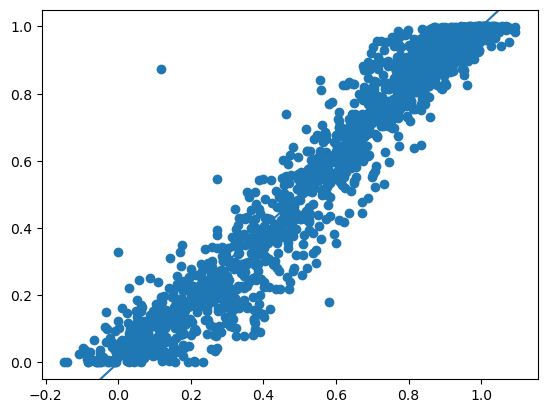

In [44]:
plt.scatter(mean,y_test_subsample)
plt.axline((0,0), slope=1)

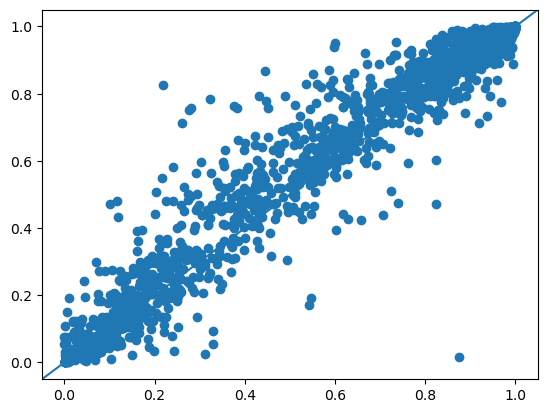

In [45]:
plt.scatter(y_test_subsample,torch.tensor(data["p0Mean"].values).float()[randperm[n_train:]][indices])
plt.axline((0,0), slope=1)

In [46]:
np.corrcoef(y_test_subsample,torch.tensor(data["p0Mean"].values).float()[randperm[n_train:]][indices])

array([[1.        , 0.97354937],
       [0.97354937, 1.        ]])

In [47]:
np.corrcoef(mean,y_test_subsample)

array([[1.        , 0.97331101],
       [0.97331101, 1.        ]])

In [48]:
from sklearn.metrics import mean_squared_error

print(mean_squared_error(y_test_subsample,torch.tensor(data["p0Mean"].values).float()[randperm[n_train:]][indices]))
print(mean_squared_error(mean,y_test_subsample))



0.0069695604
0.00635518


In [49]:
#torch.save({'model_state_dict': model.state_dict(),
#            'likelihood_state_dict': likelihood.state_dict()},'LMC_ONeil_2Latents.pth')

In [50]:
likelihood.state_dict()

OrderedDict([('noise_covar.raw_noise', tensor([-4.9380])),
             ('noise_covar.raw_noise_constraint.lower_bound',
              tensor(1.0000e-04)),
             ('noise_covar.raw_noise_constraint.upper_bound', tensor(inf))])

In [51]:
likelihood.raw_noise

Parameter containing:
tensor([-4.9380], requires_grad=True)